In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from keras.preprocessing import image

In [17]:
train_dir=r'C:\Users\Arpita\Downloads\archive (1)\brain_tumor_dataset'

In [19]:
folder =r'C:\Users\Arpita\Downloads\archive (1)\brain_tumor_dataset\yes\\'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1

print("All files renamed in the yes folder.")


All files renamed in the yes folder.


In [21]:
folder = r'C:\Users\Arpita\Downloads\archive (1)\brain_tumor_dataset\no\\'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1

print("All files renamed in the no folder.")

All files renamed in the no folder.


In [23]:
listyes = os.listdir(r'C:\Users\Arpita\Downloads\archive (1)\brain_tumor_dataset\yes\\')
number_files_yes=len(listyes)
print("Number of YES images:", number_files_yes)

listno = os.listdir(r'C:\Users\Arpita\Downloads\archive (1)\brain_tumor_dataset\no\\')
number_files_no=len(listno)
print("Number of NO images:", number_files_no)

Number of YES images: 155
Number of NO images: 98


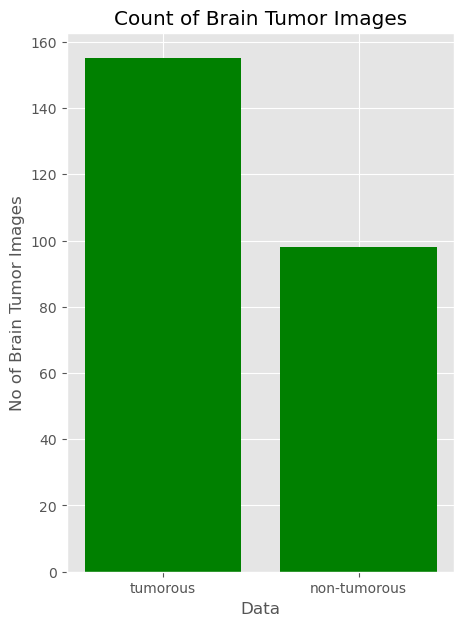

In [25]:
data = {
    'tumorous': number_files_yes,
    'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()
fig = plt.figure(figsize=(5, 7))
plt.bar(typex, values, color='green')
plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [31]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [33]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    for filename in os.listdir(file_dir):
        image_path = file_dir + '/' + filename
        image = cv2.imread(image_path)
        image = image.reshape((1,) + image.shape) 

        save_prefix = 'aug_' + filename[:-4]

        i = 0
        for batch in data_gen.flow(
            x=image,
            batch_size=1,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format="jpg"
        ):
            i += 1
            if i >= n_generated_samples:
                break

In [55]:
import os
import time


yes_path = r'C:\\Users\\Arpita\\Downloads\\archive (1)\\brain_tumor_dataset\\yes'
no_path = r'C:\\Users\\Arpita\\Downloads\\archive (1)\\brain_tumor_dataset\\no'
augmented_data_path = r'C:\\Users\\Arpita\\Downloads\\archive (1)\\augmented_data'

os.makedirs(augmented_data_path + '\\yes', exist_ok=True)
os.makedirs(augmented_data_path + '\\no', exist_ok=True)


start_time = time.time()


augmented_data(
    file_dir=yes_path,
    n_generated_samples=6,
    save_to_dir=augmented_data_path + '\\yes'
)

augmented_data(
    file_dir=no_path,
    n_generated_samples=9,
    save_to_dir=augmented_data_path + '\\no'
)


end_time = time.time()
print("Time taken:", round(end_time - start_time, 2), "seconds")


Time taken: 275.28 seconds


In [57]:
def data_summary(main_path):
    yes_path = main_path + '/yes'
    no_path = main_path + '/no'

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    n = n_pos + n_neg

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Total Samples: {n}")
    print(f"{n_pos} Tumorous images ({pos_per:.2f}%)")
    print(f"{n_neg} Non-tumorous images ({neg_per:.2f}%)")

In [59]:
data_summary(r'C:\Users\Arpita\Downloads\archive (1)\augmented_data')

Total Samples: 1811
930 Tumorous images (51.35%)
881 Non-tumorous images (48.65%)


In [61]:
listyes = os.listdir(r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\yes')
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir(r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\no')
number_files_no = len(listno)
print(number_files_no)

930
881


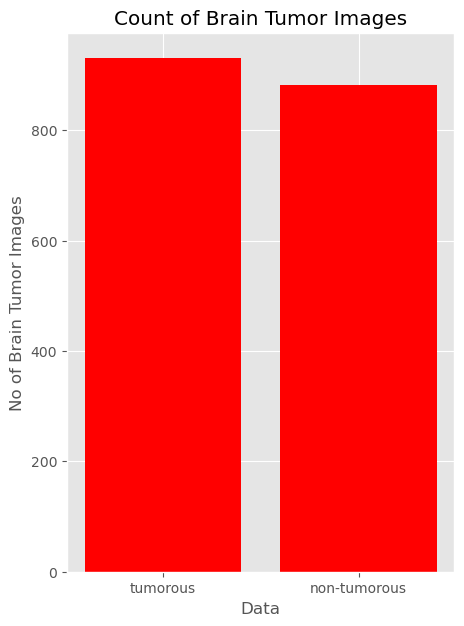

In [63]:
data = {
    'tumorous': number_files_yes,
    'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()
fig = plt.figure(figsize=(5, 7))
plt.bar(typex, values, color='red')
plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [65]:
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, 
                        left=False, right=False, labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, 
                        left=False, right=False, labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [86]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25857 sha256=9c0a333c834aade4a39e90d74df022d7fe71023a058fa3c0bea0568ddd33775f
  Stored in directory: c:\users\arpita\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils


In [67]:
import imutils

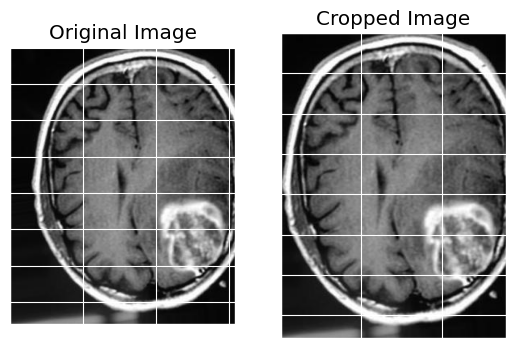

array([[[  7,   7,   7],
        [  7,   7,   7],
        [  6,   6,   6],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       [[  7,   7,   7],
        [  7,   7,   7],
        [  6,   6,   6],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       [[  7,   7,   7],
        [  7,   7,   7],
        [  6,   6,   6],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       ...,

       [[ 75,  75,  75],
        [ 77,  77,  77],
        [ 78,  78,  78],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[ 90,  90,  90],
        [ 92,  92,  92],
        [ 94,  94,  94],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[111, 111, 111],
        [113, 113, 113],
        [114, 114, 114],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]]

In [71]:
img = cv2.imread(r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\yes\aug_Y_98_0_2301.jpg')
crop_brain_tumor(img, True)

In [75]:
folder1 = r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\no\\'
folder2 = r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\yes\\'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)

for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [77]:
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    X = []
    y = []
    
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)

            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)

    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    print(f"Number of examples is: {len(X)}")
    print(f"X SHAPE is: {X.shape}")
    print(f"y SHAPE is: {y.shape}")
    
    return X, y

In [79]:
augmented_path = r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\\'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of examples is: 1811
X SHAPE is: (1811, 240, 240, 3)
y SHAPE is: (1811,)


In [81]:
def plot_sample_images(X, y, n=50):
    for label in [0, 1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

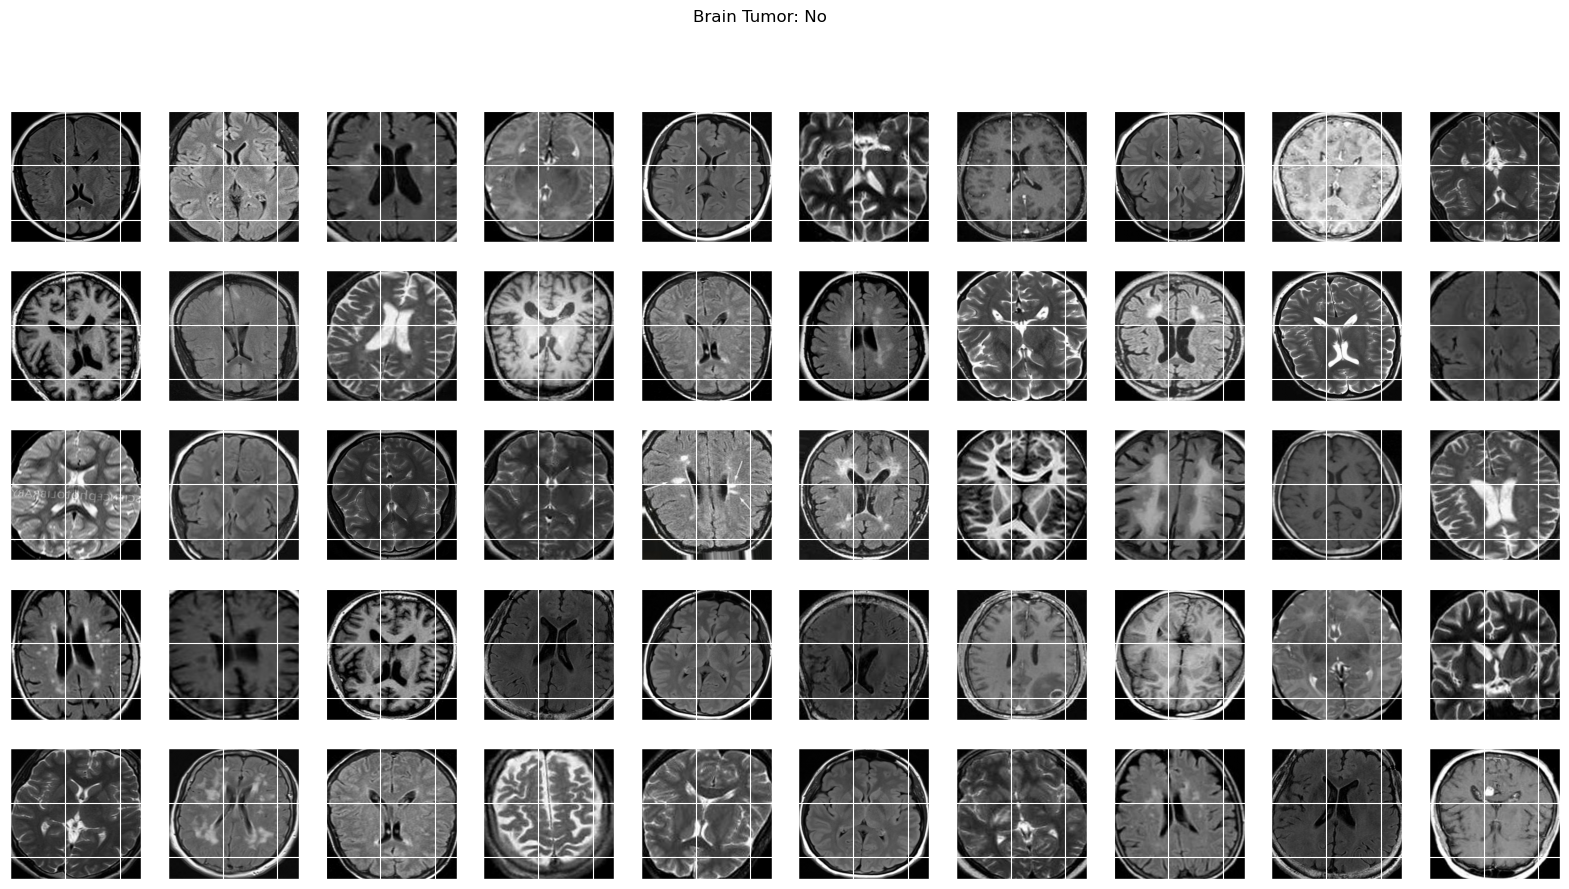

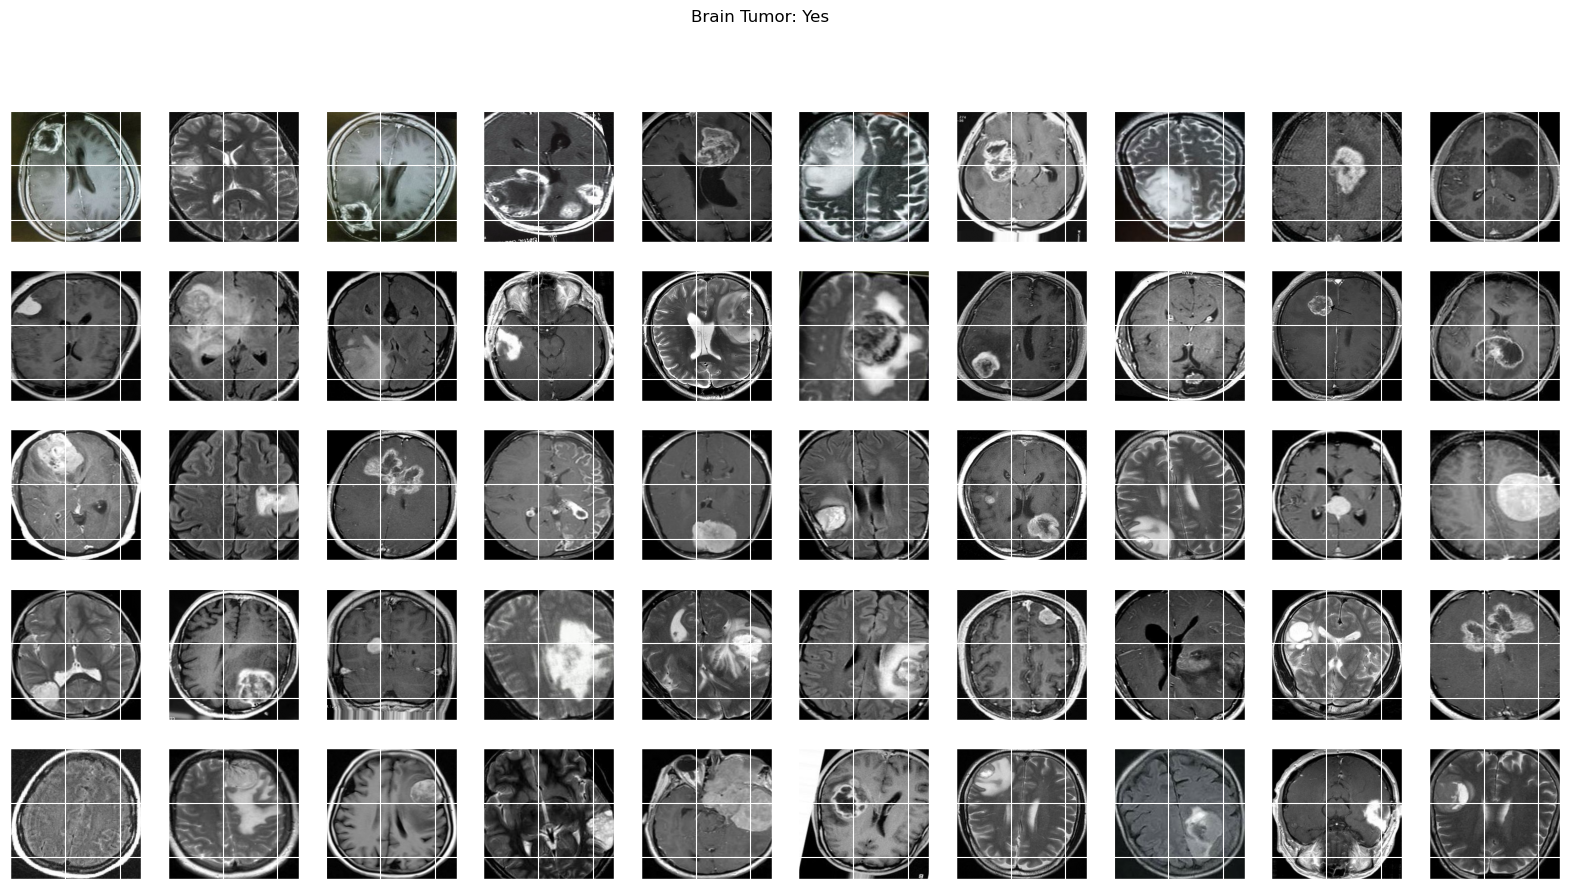

In [83]:
plot_sample_images(X,y)

In [84]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [87]:

base_dir = r'C:\Users\Arpita\Downloads\archive (1)\tumorous_and_nontumorous'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

if not os.path.isdir(valid_dir):
    os.mkdir(valid_dir)

In [89]:
base_dir = r'C:\Users\Arpita\Downloads\archive (1)\tumorous_and_nontumorous'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

infected_train_dir = os.path.join(train_dir, 'tumorous')
infected_test_dir = os.path.join(test_dir, 'tumorous')
infected_valid_dir = os.path.join(valid_dir, 'tumorous')

for folder in [infected_train_dir, infected_test_dir, infected_valid_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [91]:
healthy_train_dir = os.path.join(train_dir, 'nontumorous')
healthy_test_dir = os.path.join(test_dir, 'nontumorous')
healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')

for folder in [healthy_train_dir, healthy_test_dir, healthy_valid_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [93]:
original_dataset_tumorous = r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\yes'
original_dataset_nontumorous = r'C:\Users\Arpita\Downloads\archive (1)\augmented_data\no'

In [95]:
files = os.listdir(original_dataset_tumorous)  
fnames = []

for i in range(0, 557):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [97]:
files = os.listdir(original_dataset_tumorous)
fnames = []
for i in range(557, 742):  
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [99]:
files = os.listdir(original_dataset_tumorous)
fnames = []
for i in range(742, 929):  
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [101]:
files = os.listdir(original_dataset_nontumorous)
fnames = []
for i in range(0, 783):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [103]:
files = os.listdir(original_dataset_nontumorous)
fnames = []

for i in range(783, 881):  
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [105]:
files = os.listdir(original_dataset_nontumorous)
total_files = len(files)
print(total_files)

valid_range = range(total_files - 98, total_files) 

fnames = []
for i in valid_range:
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

881


Model Building

In [108]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=0.4,
    vertical_flip=0.4,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode='nearest'
)

test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [110]:
train_generator = train_datagen.flow_from_directory(
    'C:/Users/Arpita/Downloads/archive (1)/tumorous_and_nontumorous/train/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb')


test_generator = test_data_gen.flow_from_directory(
    'C:/Users/Arpita/Downloads/archive (1)/tumorous_and_nontumorous/test/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb')


valid_generator = valid_data_gen.flow_from_directory(
    'C:/Users/Arpita/Downloads/archive (1)/tumorous_and_nontumorous/valid/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb')


Found 1340 images belonging to 2 classes.
Found 283 images belonging to 2 classes.
Found 285 images belonging to 2 classes.


In [112]:
class_labels = train_generator.class_indices
class_name = {value: key for key, value in class_labels.items()}
print(class_name)

{0: 'nontumorous', 1: 'tumorous'}


In [114]:
base_model = VGG19(input_shape=(240, 240, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_01 = Model(base_model.input, output)

model_01.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [116]:
filepath = 'model.h5'
es = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    mode='min',
    patience=4)


cp = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


lrr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.0001)


In [118]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(
    learning_rate=0.0001,
    momentum=0.9,
    nesterov=True
)

model_01.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

In [122]:
history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5786 - loss: 0.6672 
Epoch 1: val_loss did not improve from 0.80552
10/10 ━━━━━━━━━━━━━━━━━━━━ 306s 32s/step - accuracy: 0.5777 - loss: 0.6683 - val_accuracy: 0.3474 - val_loss: 0.8182 - learning_rate: 1.0000e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5826 - loss: 0.6834 
Epoch 2: val_loss improved from 0.80552 to 0.79744, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 382s 40s/step - accuracy: 0.5816 - loss: 0.6847 - val_accuracy: 0.3509 - val_loss: 0.7974 - learning_rate: 1.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5137 - loss: 0.7108 
Epoch 3: val_loss improved from 0.79744 to 0.73983, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 352s 37s/step - accuracy: 0.5139 - loss: 0.7108 - val_accuracy: 0.4281 - val_loss: 0.7398 - learning_rate: 1.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6400 - loss: 0.6321 
Epoch 4: val_loss improved from 0.73983 to 0.71905, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 312s 32s/step - accuracy: 0.6397 - loss: 0.6330 - val_accuracy: 0.5158 - val_loss: 0.7191 - learning_rate: 1.0000e-04
Epoch 5/10
 2/10 ━━━━━━━━━━━━━━━━━━━━ 1:54 14s/step - accuracy: 0.5312 - loss: 0.7069

C:\Users\Arpita\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss did not improve from 0.71905
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 16s/step - accuracy: 0.5562 - loss: 0.7043 - val_accuracy: 0.4526 - val_loss: 0.7598 - learning_rate: 1.0000e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6521 - loss: 0.6344 
Epoch 6: val_loss did not improve from 0.71905
10/10 ━━━━━━━━━━━━━━━━━━━━ 295s 31s/step - accuracy: 0.6502 - loss: 0.6352 - val_accuracy: 0.4702 - val_loss: 0.7666 - learning_rate: 1.0000e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6113 - loss: 0.6646 
Epoch 7: val_loss improved from 0.71905 to 0.69039, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 302s 32s/step - accuracy: 0.6104 - loss: 0.6661 - val_accuracy: 0.5719 - val_loss: 0.6904 - learning_rate: 1.0000e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6453 - loss: 0.6464 
Epoch 8: val_loss improved from 0.69039 to 0.61588, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 304s 32s/step - accuracy: 0.6411 - loss: 0.6488 - val_accuracy: 0.6737 - val_loss: 0.6159 - learning_rate: 1.0000e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6587 - loss: 0.6467 
Epoch 9: val_loss did not improve from 0.61588
10/10 ━━━━━━━━━━━━━━━━━━━━ 305s 32s/step - accuracy: 0.6542 - loss: 0.6484 - val_accuracy: 0.5684 - val_loss: 0.7126 - learning_rate: 1.0000e-04
Epoch 10/10
 2/10 ━━━━━━━━━━━━━━━━━━━━ 1:55 14s/step - accuracy: 0.5703 - loss: 0.7050
Epoch 10: val_loss did not improve from 0.61588
10/10 ━━━━━━━━━━━━━━━━━━━━ 168s 16s/step - accuracy: 0.5516 - loss: 0.7127 - val_accuracy: 0.6211 - val_loss: 0.6649 - learning_rate: 1.0000e-04


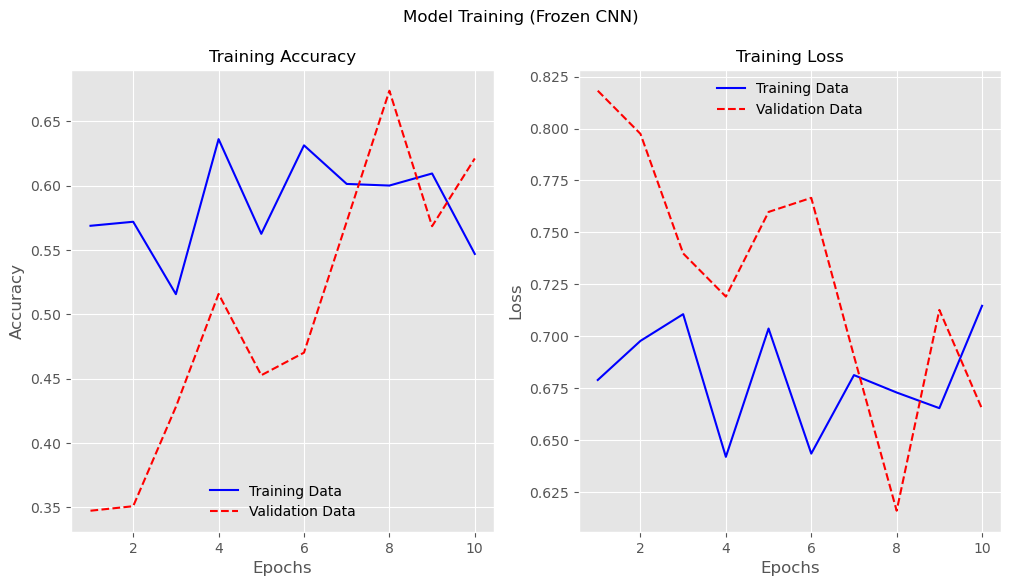

In [124]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

max_epoch = len(history_01.history['accuracy'])
epochs_list = list(range(1, max_epoch + 1))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='--', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center')
ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='--', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center')

plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

In [128]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')

model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [130]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.7289 - loss: 0.5718


C:\Users\Arpita\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.8178 - loss: 0.5093


In [132]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Accuracy: {vgg_val_eval_01[1]}')

print(f'Test Loss: {vgg_test_eval_01[0]}')
print(f'Test Accuracy: {vgg_test_eval_01[1]}')

Validation Loss: 0.6649010181427002
Validation Accuracy: 0.621052622795105
Test Loss: 0.6085026264190674
Test Accuracy: 0.6607773900032043


In [135]:
filenames = test_generator.filenames
nb_sample = len(filenames)

VGG_prediction_01 = model_01.predict(test_generator, steps=10, verbose=1)
y_pred = np.argmax(VGG_prediction_01, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 12s/step


In [139]:
base_model = VGG19(include_top=False, input_shape=(240, 240, 3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [145]:
base_model = VGG19(include_top=False, input_shape=(240, 240, 3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4688, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model_02.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 143,045,650 (545.68 MB)

 Trainable params: 127,740,882 (487.29 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [147]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_02.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

C:\Users\Arpita\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [149]:
history_02 = model_02.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=5,                          
    callbacks=[es, cp, lrr],
    validation_data=valid_generator
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5066 - loss: 0.7732 
Epoch 1: val_loss did not improve from 0.61588
10/10 ━━━━━━━━━━━━━━━━━━━━ 305s 31s/step - accuracy: 0.5100 - loss: 0.7691 - val_accuracy: 0.3439 - val_loss: 0.9694 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5968 - loss: 0.6911 
Epoch 2: val_loss did not improve from 0.61588
10/10 ━━━━━━━━━━━━━━━━━━━━ 291s 31s/step - accuracy: 0.5965 - loss: 0.6904 - val_accuracy: 0.4316 - val_loss: 0.7625 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5721 - loss: 0.6974 
Epoch 3: val_loss did not improve from 0.61588
10/10 ━━━━━━━━━━━━━━━━━━━━ 290s 30s/step - accuracy: 0.5755 - loss: 0.6961 - val_accuracy: 0.4175 - val_loss: 0.8081 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6085 - loss: 0.6683 
Epoch 4: val_loss did not improve from 0.61588
10/10 ━━━━━━━━━━━━━━━━━━━━ 290s 30s/step 

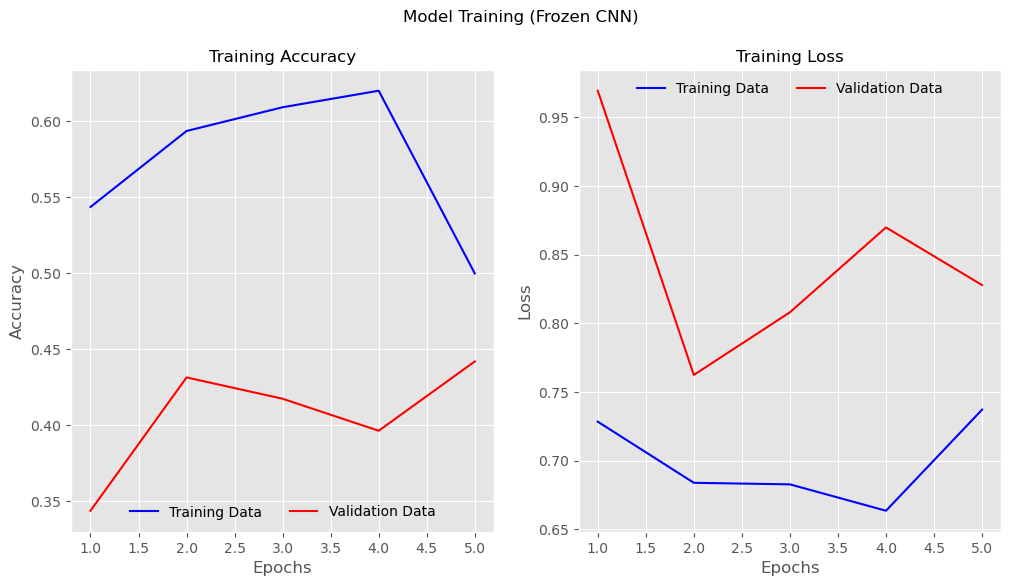

In [151]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

max_epoch = len(history_02.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

In [155]:
if not os.path.isdir('model_weights'):
    os.mkdir('model_weights')

model_02.save_weights('model_weights/vgg19_model_02.weights.h5', overwrite=True)

In [157]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 128s 14s/step - accuracy: 0.6824 - loss: 0.6007
9/9 ━━━━━━━━━━━━━━━━━━━━ 127s 14s/step - accuracy: 0.6951 - loss: 0.5437


In [182]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)


model_03 = Model(inputs=base_model.input, outputs=output)


model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_03a = model_03.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[
        ModelCheckpoint("model_03_base.h5", save_best_only=True, monitor='val_accuracy'),
        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5206 - loss: 2.3283 

42/42 ━━━━━━━━━━━━━━━━━━━━ 915s 22s/step - accuracy: 0.5210 - loss: 2.3037 - val_accuracy: 0.3439 - val_loss: 0.7204
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5887 - loss: 0.6603 

42/42 ━━━━━━━━━━━━━━━━━━━━ 906s 22s/step - accuracy: 0.5886 - loss: 0.6603 - val_accuracy: 0.4632 - val_loss: 0.7310
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6240 - loss: 0.6309 

42/42 ━━━━━━━━━━━━━━━━━━━━ 898s 21s/step - accuracy: 0.6238 - loss: 0.6311 - val_accuracy: 0.7018 - val_loss: 0.6560
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 738s 18s/step - accuracy: 0.6541 - loss: 0.6197 - val_accuracy: 0.4000 - val_loss: 0.8397
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 747s 18s/step - accuracy: 0.6165 - loss: 0.6058 - val_accuracy: 0.6246 - val_loss: 0.6512


In [184]:
if not os.path.isdir('model_weights'):
    os.mkdir('model_weights')
model_03.save_weights('model_weights/vgg_unfrozen.weights.h5', overwrite=True)
model_03.load_weights('model_weights/vgg_unfrozen.weights.h5')
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 140s 16s/step - accuracy: 0.7336 - loss: 0.5196
9/9 ━━━━━━━━━━━━━━━━━━━━ 133s 15s/step - accuracy: 0.8389 - loss: 0.4414


In [1]:
import gradio as gr
import numpy as np
import logging
from tensorflow.keras.models import load_model
from PIL import Image

# -------- Load Model --------
try:
    model = load_model("model_03_base.h5")
    logging.info("Model loaded successfully.")
except Exception as e:
    logging.error("Error loading model: %s", e)
    raise e

# -------- Preprocessing Function --------
def preprocess_image(img):
    img = img.resize((240, 240))  # Match input shape from model
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# -------- Prediction Function --------
def predict_image(img):
    try:
        logging.info("Received image for prediction.")
        processed = preprocess_image(img)
        pred = model.predict(processed)[0]  # Softmax gives 2 probabilities
        class_index = np.argmax(pred)

        result = "Tumor Detected ✅" if class_index == 1 else "No Tumor ❌"
        logging.info(f"Prediction: {pred} → {result}")
        return result
    except Exception as e:
        logging.error("Prediction error: %s", e)
        return "Error processing the image."

# -------- Gradio UI --------
app = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Brain MRI"),
    outputs=gr.Textbox(label="Prediction"),
    title="🧠 Brain Tumor Classifier",
    description="Upload an MRI brain image to check if it's tumorous or not.",
    theme="default"
)

# -------- Launch App
if __name__ == "__main__":
    app.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
